# Time Series Classification and Clustering

The Euclidean distance between two time series $Q$ and $C$ of length $n$ is defined as

$$d(Q,C) = \sqrt{\sum^n_{i=1}[Q(i)-C(i)]^2}$$


With a good similarity measure, small changes in two time series should result in small changes in their similarity.  With respect to Euclidean distance this is true for changes in the y-axis, but it is not true for changes in the time axis (i.e. compression and stretching).  Consider the following example.

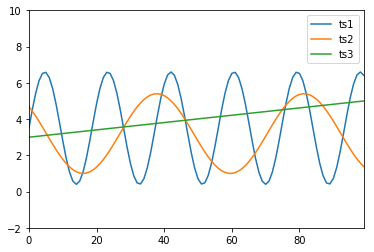

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

x=np.linspace(0,50,100)
ts1=pd.Series(3.1*np.sin(x/1.5)+3.5)
ts2=pd.Series(2.2*np.sin(x/3.5+2.4)+3.2)
ts3=pd.Series(0.04*x+3.0)

ts1.plot()
ts2.plot()
ts3.plot()

plt.ylim(-2,10)
plt.legend(['ts1','ts2','ts3'])
plt.show()

In the above example, it is clear that $ts1$ and $ts2$ are most similar (they are both $sin$ functions under different transformations).  $ts3$ is clearly the most different. Let's compute the Euclidean distance $d(ts1,ts2)$ and $d(ts1,ts3)$ to see if the Euclidean distance measure agrees with what our intuition tells us.  Let's first create a function that computes the Euclidean distance between two time series.

In [4]:
def euclid_dist(t1,t2):
    return np.sqrt(sum((t1-t2)**2))

Let's now find the Euclidean distance between $ts1$ and $ts2$

In [5]:
print(euclid_dist(ts1,ts2))

26.959216037969345


and the Euclidean distance between $ts1$ and $ts3$

In [6]:
print(euclid_dist(ts1,ts3))

23.189249190311056


This is not good because according to the Euclidean distance measure, $ts1$ is more similar to $ts3$ than to $ts2$ which contradicts our intuition.  This is the problem with using the Euclidean distance measure.  It often produced pessimistic similarity measures when it encounters distortion in the time axis.  The way to deal with this is to use dynamic time warping.

## Dynamic Time Warping

Dynamic time warping finds the optimal non-linear alignment between two time series.  The Euclidean distances between alignments are then much less susceptable to pessimistic similarity measurements due to distortion in the time axis.  There is a price to pay for this, however, because dynamic time warping is quadratic in the length of the time series used.

Dynamic time warping works in the following way. Consider two time series $Q$ and $C$ of the same length $n$ where $$Q=q_1,q_2,...,q_n$$ and $$C=c_1,c_2,...,c_n$$ The first thing we do is construct an $n\times n$ matrix whose $i,j^{th}$ element is the Euclidean distance between $q_i$ and $c_j$.  We want to find a path through this matrix that minimizes the cumulative distance.  This path then determines the optimal alignment between the two time series.  It should be noted that it is possible for one point in a time series to be mapped to multiple points in the other time series.

Let's call the path $W$ where $$W=w_1,w_2,...,w_K$$ where each element of $W$ represents the distance between a point $i$ in $Q$ and a point $j$ in $C$ i.e. $w_k=(q_i-c_j)^2$

So we want to find the path with the minimum Euclidean distance $$W^*= \min_W(\sqrt{\sum_{k=1}^Kw_k})$$ The optimal path is found via dynamic programming, specifically the following recursive function. $$DTW(i,j)=d(q_i,c_j)+\min( DTW(i-1,j-1),DTW(i-1,j),DTW(i,j-1))$$ 

In [7]:
def DTWDistance(s1, s2):
    DTW={}
    
    for i in range(len(s1)):
        DTW[(i, -1)] = float('inf')
    for i in range(len(s2)):
        DTW[(-1, i)] = float('inf')
    DTW[(-1, -1)] = 0

    for i in range(len(s1)):
        for j in range(len(s2)):
            dist= (s1[i]-s2[j])**2
            DTW[(i, j)] = dist + min(DTW[(i-1, j)],DTW[(i, j-1)], DTW[(i-1, j-1)])
    return np.sqrt(DTW[len(s1)-1, len(s2)-1]), DTW

In [8]:
_, DTWMatrix = DTWDistance(ts1,ts2)

In [12]:
M = np.zeros((len(ts1), len(ts2)))

In [14]:
for i in range(len(ts1)):
    for j in range(len(ts2)):
        M[i,j] = DTWMatrix[(i,j)]

In [16]:
import seaborn as sns

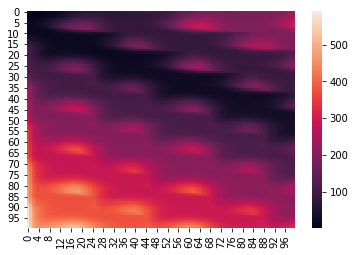

In [17]:
sns.heatmap(M)

Now let's compute the Euclidean distance between $ts1$ and $ts2$ using dynamic time warping.

In [6]:
print(DTWDistance(ts1,ts2))

17.929718468641138


and now the dynamic time warping distance between $ts1$ and $ts3$

In [7]:
print(DTWDistance(ts1,ts3))

21.549494824404572


## Classification

In [8]:
train = pd.read_csv('./data/train.csv', delimiter='\t', header=None)
test = pd.read_csv('./data/test.csv', delimiter='\t', header=None)

In [9]:
train.head()

,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,60
0,-0.376936,1.224864,0.343874,0.328454,-0.337609,1.026514,-1.330996,-0.657800,1.446077,-0.846397,...,-1.568165,1.021863,-1.429748,1.356966,1.372781,0.663558,0.918346,-1.311742,-1.197146,1
1,0.644406,0.413269,-0.862278,-1.497386,-0.421458,-0.214215,-1.292131,0.956898,-1.216140,-0.588536,...,-0.802528,-1.121287,0.989319,-1.109687,0.219856,0.630034,1.398140,0.085742,0.024997,1
2,-0.978667,-0.406232,0.822429,-1.408242,-1.676734,-0.490632,1.404598,1.168600,-1.703254,0.972810,...,-0.762884,1.382972,-0.869103,1.277252,-0.198967,0.966809,0.666129,0.106996,0.082715,1
3,-0.236537,-0.098175,0.367092,1.366860,0.498281,-0.300223,1.715634,0.902108,-0.218132,-1.430721,...,-1.499604,0.406744,1.289153,-1.119731,-0.995985,1.651135,-1.187098,0.025463,-0.841518,1
4,1.490735,1.325243,1.626829,-0.317056,-1.098990,-0.022213,0.596980,1.667339,-0.206153,-1.376627,...,1.029995,-1.496161,-1.167442,1.484208,-0.373020,-0.843281,-0.209794,0.137724,0.716542,1


In [10]:
X_train = train.iloc[:, :-1]
y_train = train.iloc[:,-1]
X_test = test.iloc[:, :-1]
y_test = test.iloc[:,-1]

In [11]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(metric=DTWDistance)

The same idea can also be applied to k-means clustering.  In this algorithm, the number of clusters is set _apriori_ and similar time series are clustered together.

In [12]:
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30,
           metric=<function DTWDistance at 0x00000152FA7D1268>,
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [27]:
y_pred = knn.predict(X_test)

In [24]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          1       0.35      1.00      0.52        50
          2       0.00      0.00      0.00        50
          3       1.00      0.86      0.92        50
          4       0.94      0.94      0.94        50
          5       1.00      0.54      0.70        50
          6       1.00      0.68      0.81        50

avg / total       0.71      0.67      0.65       300



# Your turn!

Calculating `DTWDistance` is awfully slow. Instead let's replace the inner loop by looking only on a window of size `w` around $s1[i]$ (that is, between $s1[i]-w$ and $s1[i]+w$).

In [25]:
def FastDTWDistance(s1, s2, **kwargs):
    w = kwargs["metric_params"]["w"] #sklearn 0.19
    w = kwargs["w"] #sklearn 0.20
    #/* your function here */
    pass

In [20]:
def TestFastDTWDistance(s1, s2, w):
    DTW={}
    
    w = max(w, abs(len(s1)-len(s2)))
    
    for i in range(-1,len(s1)):
        for j in range(-1,len(s2)):
            DTW[(i, j)] = float('inf')
    DTW[(-1, -1)] = 0
  
    for i in range(len(s1)):
        for j in range(max(0, i-w), min(len(s2), i+w)):
            dist= (s1[i]-s2[j])**2
            DTW[(i, j)] = dist + min(DTW[(i-1, j)],DTW[(i, j-1)], DTW[(i-1, j-1)])
    return np.sqrt(DTW[len(s1)-1, len(s2)-1])

You can call it as follows:

In [26]:
fast_knn_dtw = KNeighborsClassifier(metric=FastDTWDistance, metric_params={"w":5})

Another way to speed things up is to use the _LB Keogh_ lower bound of dynamic time warping.  It is defined as $$LBKeogh(Q,C)= \sqrt{\sum_{i=1}^n (c_i-U_i)^2I(c_i > U_i)+(c_i-L_i)^2I(c_i < L_i)}$$
where $U_i$ and $L_i$ are upper and lower bounds for time series $Q$ which are defined as $U_i=max(q_{i-r}:q_{i+r})$ and $L_i=min(q_{i-r}:q_{i+r})$ for a reach $r$ and $I(\cdot)$ is the indicator function. Here, `r` is a hyperparameter (user-given).

In [14]:
def LBKeoghDistance(s1,s2,**kwargs):
    LB_sum=0
    r = kwargs["metric_params"]["r"]
    pass

### Solution:

In [ ]:
def LBKeoghDistance(s1,s2,**kwargs):
    LB_sum=0
    for ind,i in enumerate(s1):
        
        lower_bound=min(s2[(ind-r if ind-r>=0 else 0):(ind+r)])
        upper_bound=max(s2[(ind-r if ind-r>=0 else 0):(ind+r)])
        
        if i>upper_bound:
            LB_sum=LB_sum+(i-upper_bound)**2
        elif i<lower_bound:
            LB_sum=LB_sum+(i-lower_bound)**2
    
    return np.sqrt(LB_sum)